# **MLB Player Digital Engagementコンペ概略**&#x1f600; 

## ※ English page is here : https://www.kaggle.com/chumajin/eda-of-mlb-for-starter-english-ver

## このコンペは、MLBのplayer idごとに、次の日(将来)にファンがデジタルコンテンツへのエンゲージメント（「反応」「行動」みたいなもの)をどれくらい起こすかというのを数値化したもの(target)を予測するコンペだと思います。targetは1～4で、それぞれ異なる指標で4つあって、0-100のスケールで数値化したものだそうです。
   (コメントいただきました。ありがとうございます!!　たしかにサポーターなどのtwitterの書き込みとか、どこかのサイトへのアクセスなどそういうのを想像するとイメージしやすいですね。)



## もし、少しでもお役に立てば、**upvote**いただけたら嬉しいです！　他notebookでもupvoteいただけた方いつもありがとうございます。

## また、基本的には、この事務局のスターターを見て、EDAを理解していきました(一部抜粋)。ありがとうございます。

## こちらもupvoteお願いいたします。

https://www.kaggle.com/ryanholbrook/getting-started-with-mlb-player-digital-engagement

In [ ]:
import gc
import sys
import warnings
from pathlib import Path

import os

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
warnings.simplefilter("ignore")

# 0. 何を予測するか (submissionファイルから見ちゃいます)

In [ ]:
example_sample_submission = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/example_sample_submission.csv")
example_sample_submission

playeridごとに、次の日(将来)にファンがデジタルコンテンツへのエンゲージメント（「反応」「行動」みたいなもの)をどれくらい起こすかというのを数値化したもの(target)を予測するコンペ。

targetは1～4で、それぞれ異なる指標で4つあって、0-100のスケールで数値化したものだそうです。


## 0.1 どの情報から推測 ? (先にテストデータを見ちゃいます)

In [ ]:
example_test = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/example_test.csv")
example_test

パッと見て、submissionに出てくるplayer IDとかがすぐわかる感じではなさそう。json形式でいろいろな情報が入っていそう。


テストデータは1日に1行のデータからなっている。


例えば、starterコードからの関数を使用すると、以下のように展開できる。

In [ ]:
# Helper function to unpack json found in daily data
def unpack_json(json_str):
    return np.nan if pd.isna(json_str) else pd.read_json(json_str)

In [ ]:
example_test.head(3)

example_test["games"].iloc[0] の中身を見てみる

In [ ]:
unpack_json(example_test["games"].iloc[0])

example_test["rosters"].iloc[0] の中身を見てみる

In [ ]:
unpack_json(example_test["rosters"].iloc[0])

この辺の情報から、player idごとに次の日のtarget1～4という評価項目の期待値を推測するコンペだと思います。

---------以上を踏まえて、trainデータなど他のデータを見ていきます---------

# 1. train.csv

In [ ]:
# 読み込みに少し時間かかります。
training = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/train.csv")
training

In [ ]:
# dateはdatetimeに変換
training['date'] = pd.to_datetime(training['date'], format="%Y%m%d")

In [ ]:
training.info()

1216日分のデータ。nullデータは無し。nanデータがところどころにある。

---------------------------------------------------------------------

## ここから**カラムごとにデータがあるところのjsonを事例として1つ見てみます**。

上述したように、train.csvの中身も1つのセルの中にjsonファイル形式で、dataframeがさらにそれぞれ入っているような複雑な形をしています。

(結果から言うと、全部で1216日分のデータの1日に対して、約11個(nanもあるのでも少し少ないですが)のDataFrameが情報量としてぶら下がっているイメージで、かなりの情報量です。

ので、ここから少し長いです。イメージだけつかんで、読み流しても良いかもです。)


In [ ]:
training.columns

1つ1つ入力するのが、めんどくさいので、naを抜いて、n番目(0だと一番上)のサンプルをdataframeにしてcolumn名と中身を見る関数を作っちゃいます。

In [ ]:
def exshow(col,n):
    tmp = training[col]
    tmp = tmp.dropna()
    tmpdf = unpack_json(tmp.iloc[n])
    print(tmpdf.columns)
    return tmpdf

## 1.1 nextDayPlayerEngagement (train.csvのcolumn1番目)
翌日以降のすべてのモデリング ターゲットを含むネストされた JSON。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("nextDayPlayerEngagement",0)
tmpdf

* engagementMetricsDate - 米国太平洋時間に基づくプレーヤーエンゲージメント指標の日付（前日のゲーム、名簿、フィールド統計、トランザクション、賞などと一致します）。
* playerId
* target1
* target2
* target3
* target4


target1-target4は、0から100のスケールでのデジタルエンゲージメントの毎日のインデックスです。

ここから、plyaerIdと次の日以降のtarget1～4を抜くんですね。

## 1.2 games(train.csvのcolumn2番目)
特定の日のすべてのゲーム情報を含むネストされた JSON。レギュラー シーズン、ポストシーズン、オールスター ゲームに加えて、スプリング トレーニングとエキシビション ゲームが含まれています。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("games",1) # 0番目（1番上はデータが一行しかなかったので、1にしました。)
tmpdf

カラムの意味の翻訳は↓を開いてください。(長いので、hideしています。)

* gamePk  : ゲームの一意の識別子。
* gameType  :   ゲームの種類、さまざまな種類がここにあります。
* season : 
* gameDate : 
* gameTimeUTC  : UTCでの始球式。
* resumeDate  :  タイムゲームが再開されました（放棄された場合、それ以外の場合はnull）。
* resumedFrom  :  タイムゲームは元々放棄されていました（放棄された場合、それ以外の場合はnull）。
* codedGameState  :  ゲームのステータスコード、さまざまなタイプがここにあります。
* detailedGameState  :  ゲームのステータス、さまざまな種類がここにあります。
* isTie  :  ブール値。ゲームが引き分けで終了した場合はtrue。
* gameNumber  :  ダブルヘッダーを区別するためのゲーム番号フラグ
* doubleHeader  :  YはDH、Nはシングルゲーム、Sはスプリット
* dayNight  :  スケジュールされた開始時間の昼または夜のフラグ。
* scheduledInnings  :  予定イニング数。
* gamesInSeries  :  現在のシリーズのゲーム数。
* seriesDescription  :  現在のシリーズのテキスト説明。
* homeId  :  ホームチームの一意の識別子。
* homeName  :  ホームチーム名。
* homeAbbrev  :  ホームチームの略語。
* homeWins  :  ホームチームのシーズンの現在の勝利数。
* homeLosses  :  ホームチームのシーズンでの現在の損失数。
* homeWinPct  :  ホームチームの現在の勝率。
* homeWinner  :  ブール値。ホームチームが勝った場合はtrue。
* homeScore  :  ホームチームが得点するラン。
* awayId  :  アウェイチームの一意の識別子。
* awayName  :  アウェイチームの一意の識別子。
* awayAbbrev  :  アウェイチームの略。
* awayWins  :  アウェイチームのシーズンの現在の勝利数。
* awayLosses  :  アウェイチームのシーズン中の現在の敗北数。
* awayWinPct  :  アウェイチームの現在の勝率。
* awayWinner  :  ブール値。離れたチームが勝った場合はtrue。
* awayScore  :  アウェイチームが得点したラン。

## 1.3 rosters(train.csvのcolumn3番目)
特定の日のすべての名簿情報を含むネストされた JSON。インシーズンとオフシーズンのチーム名簿が含まれます。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("rosters",0) 
tmpdf

* playerId-プレーヤーの一意の識別子。
* gameDate
* teamId-そのプレーヤーがその日にいるteamId。
* statusCode-名簿ステータスの略語。
* status-説明的な名簿のステータス。

## 1.4 playerBoxScores(train.csvのcolumn4番目)
特定の日のプレイヤー ゲーム レベルで集計されたゲーム統計を含むネストされた JSON。レギュラーシーズン、ポストシーズン、オールスターゲームが含まれます。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("playerBoxScores",0) 
tmpdf.head(5)

カラムの意味の翻訳は↓を開いてください。(長いので、hideしています。)

* home  : バイナリ、ホームチームの場合は1、離れている場合は0。
* gamePk  :   ゲームの一意の識別子。
* gameDate : 
* gameTimeUTC  : UTCでの始球式。
* teamId  :   チームの一意の識別子。
* teamName : 
* playerId  : プレーヤーの一意の識別子。
* playerName : 
* jerseyNum : 
* positionCode  : 番号の位置コード、詳細はこちらです。
* positionName  :  テキスト位置の表示、詳細はこちらです。
* positionType  :  ポジショングループ、詳細はこちらです。
* battingOrder  :  形式：「###」。最初の桁は打順スポットを示し、次の2桁はそのプレーヤーがその打順スポットを占めた順序を示します。例：「300」は、打順の3番目のスポットのスターターを示します。 4人目（900、901、902以降）が打順9位を占めることを示す「903」。ゲームに登場した場合にのみ入力されます。
* gamesPlayedBatting  :  プレーヤーが打者、ランナー、または野手としてゲームに参加した場合は1。
* flyOuts  :  ゲームの合計フライアウト。
* groundOuts  :  ゲームのトータルグラウンドアウト。
* runsScored  :  ゲームの合計ランが記録されました。
* doubles  :  ゲームの合計は2倍です。
* triples  :  ゲームの合計トリプル。
* homeRuns  :  ゲームの総本塁打。
* strikeOuts  :  ゲームの合計三振。
* baseOnBalls  :  ゲームの合計ウォーク。
* intentionalWalks  :  ゲームの故意四球。
* hits  :  ゲームの総ヒット数。
* hitByPitch  :  ピッチによるゲームの合計ヒット。
* atBats  :  でのゲーム合計
* caughtStealing  :  ゲームの合計が盗塁をキャッチしました。
* stolenBases  :  ゲームの盗塁総数。
* groundIntoDoublePlay  :  ゲームの合計併殺はに基づいています。
* groundIntoTriplePlay  :  ゲームの合計 3 回プレイが基礎になります。
* plateAppearances  :  ゲームの総打席。
* totalBases  :  ゲームの総拠点数。
* rbi  :  ゲームの合計打点。
* leftOnBase  :  ゲームの総ランナーはベースに残った。
* sacBunts  :  ゲームの合計犠牲バント。
* sacFlies  :  ゲームの総犠牲フライ。
* catchersInterference  :  ゲームのトータルキャッチャーの干渉が発生しました。
* pickoffs  :  ゲームの合計回数がベースから外れました。
* gamesPlayedPitching :  バイナリ、プレーヤーが投手としてゲームに参加した場合は 1。
* gamesStartedPitching :  バイナリ、プレーヤーがゲームの先発投手だった場合は1。
* completeGamesPitching  :  バイナリ、完投でクレジットされている場合は1。
* shutoutsPitching  :  バイナリ、完封でクレジットされている場合は1。
* winsPitching  :  バイナリ、勝利でクレジットされている場合は 1。
* lossesPitching  :  バイナリ、損失がクレジットされている場合は1。
* flyOutsPitching  :  許可されたフライアウトのゲーム合計。
* airOutsPitching  :  エアアウト（フライアウト+ポップアウト）のゲーム合計が許可されます。
* groundOutsPitching  :  ゲームの合計グラウンドアウトが許可されます。
* runsPitching  :  ゲームの合計実行が許可されます。
* doublesPitching  :  ゲームの合計は2倍になります。
* triplesPitching  :  ゲームの合計トリプルが許可されます。
* homeRunsPitching  :  ゲームの合計ホームランが許可されます。
* strikeOutsPitching  :  ゲームの合計三振が許可されます。
* baseOnBallsPitching  :  ゲームの合計歩行が許可されます。
* intentionalWalksPitching  :  ゲームの故意四球の合計が許可されます。
* hitsPitching  :  許可されるゲームの合計ヒット数。
* hitByPitchPitching  :  許可されたピッチによるゲームの合計ヒット。
* atBatsPitching  :  でのゲーム合計
* caughtStealingPitching  :  ゲームの合計は、盗みをキャッチしました。
* stolenBasesPitching  :  ゲームの盗塁の合計は許可されます。
* inningsPitched  :  ゲームの総投球回。
* saveOpportunities  :  バイナリ、保存の機会がある場合は1。
* earnedRuns  :  ゲームの合計自責点は許可されています。
* battersFaced  :  直面したゲームの総打者。
* outsPitching  :  ゲームの合計アウトが記録されました。
* pitchesThrown  :  投げられた投球のゲーム総数。
* balls  :  投げられたゲームの合計ボール。
* strikes  :  スローされたゲームの合計ストライク。
* hitBatsmen  :  ゲームの総死球打者。
* balks  :  ゲームの合計はボークします。
* wildPitches  :  投げられた暴投のゲーム総数。
* pickoffsPitching  :  ゲームのピックオフの総数。
* rbiPitching  :  打点のゲーム総数は許可されています。
* inheritedRunners  :  継承されたランナーのゲーム合計を想定。
* inheritedRunnersScored :  得点した継承されたランナーのゲーム合計。
* catchersInterferencePitching  :  キャッチャーの干渉のゲーム合計はバッテリーによって発生しました。
* sacBuntsPitching  :  ゲームの犠牲バントの合計が許可されます。
* sacFliesPitching  :  ゲームの犠牲フライは許可されています。
* saves  :  バイナリ、保存でクレジットされている場合は1。
* holds  :  バイナリ、保留がクレジットされている場合は1。
* blownSaves  :  バイナリ、ブローセーブでクレジットされている場合は1。
* assists  :  ゲームのアシスト総数。
* putOuts  :  ゲームの刺殺の総数。
* errors  :  ゲームのエラーの総数。
* chances  :  ゲームのトータルフィールディングチャンス。

## 1.5 teamBoxScores(train.csvのcolumn5番目)
特定の日のチーム ゲーム レベルで集計されたゲーム統計を含むネストされた JSON。レギュラーシーズン、ポストシーズン、オールスターゲームが含まれます。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("teamBoxScores",0) 
tmpdf.head(5)

カラムの意味の翻訳は↓を開いてください。(長いので、hideしています。)

* home  : バイナリ、ホームチームの場合は1、離れている場合は0。
* teamId  :   チームの一意の識別子。
* gamePk  :   ゲームの一意の識別子。
* gameDate : 
* gameTimeUTC  : UTCでの始球式。
* flyOuts  :  ゲームの合計フライアウト。
* groundOuts  :  ゲームのトータルグラウンドアウト。
* runsScored  :  ゲームの合計ランが記録されました。
* doubles  :  ゲームの合計は2倍です。
* triples  :  ゲームの合計トリプル。
* homeRuns  :  ゲームの総本塁打。
* strikeOuts  :  ゲームの合計三振。
* baseOnBalls  :  ゲームの合計ウォーク。
* intentionalWalks  :  ゲームの故意四球。
* hits  :  ゲームの総ヒット数。
* hitByPitch  :  ピッチによるゲームの合計ヒット。
* atBats  :  でのゲーム合計
* caughtStealing  :  ゲームの合計が盗塁をキャッチしました。
* stolenBases  :  ゲームの盗塁総数。
* groundIntoDoublePlay  :  ゲームの合計併殺はに基づいています。
* groundIntoTriplePlay  :  ゲームの合計 3 回プレイが基礎になります。
* plateAppearances  :  ゲームの総打席。
* totalBases  :  ゲームの総拠点数。
* rbi  :  ゲームの合計打点。
* leftOnBase  :  ゲームの総ランナーはベースに残った。
* sacBunts  :  ゲームの合計犠牲バント。
* sacFlies  :  ゲームの総犠牲フライ。
* catchersInterference  :  ゲームのトータルキャッチャーの干渉が発生しました。
* pickoffs  :  ゲームの合計回数がベースから外れました。
* airOutsPitching  :  エアアウト（フライアウト+ポップアウト）のゲーム合計が許可されます。
* groundOutsPitching  :  ゲームの合計グラウンドアウトが許可されます。
* runsPitching  :  ゲームの合計実行が許可されます。
* doublesPitching  :  ゲームの合計は2倍になります。
* triplesPitching  :  ゲームの合計トリプルが許可されます。
* homeRunsPitching  :  ゲームの合計ホームランが許可されます。
* strikeOutsPitching  :  ゲームの合計三振が許可されます。
* baseOnBallsPitching  :  ゲームの合計歩行が許可されます。
* intentionalWalksPitching  :  ゲームの故意四球の合計が許可されます。
* hitsPitching  :  許可されるゲームの合計ヒット数。
* hitByPitchPitching  :  許可されたピッチによるゲームの合計ヒット。
* atBatsPitching  :  でのゲーム合計
* caughtStealingPitching  :  ゲームの合計は、盗みをキャッチしました。
* stolenBasesPitching  :  ゲームの盗塁の合計は許可されます。
* inningsPitched  :  ゲームの総投球回。
* earnedRuns  :  ゲームの合計自責点は許可されています。
* battersFaced  :  直面したゲームの総打者。
* outsPitching  :  ゲームの合計アウトが記録されました。
* hitBatsmen  :  ゲームの総死球打者。
* balks  :  ゲームの合計はボークします。
* wildPitches  :  投げられた暴投のゲーム総数。
* pickoffsPitching  :  ゲームのピックオフの総数。
* rbiPitching  :  打点のゲーム総数は許可されています。
* inheritedRunners  :  継承されたランナーのゲーム合計を想定。
* inheritedRunnersScored :  得点した継承されたランナーのゲーム合計。
* catchersInterferencePitching  :  キャッチャーの干渉のゲーム合計はバッテリーによって発生しました。
* sacBuntsPitching  :  ゲームの犠牲バントの合計が許可されます。
* sacFliesPitching  :  ゲームの犠牲フライは許可されています。

## 1.6 transactions(train.csvのcolumn6番目)
特定の日の MLB チームに関係するすべてのトランザクション情報を含むネストされた JSON。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("transactions",1) 
tmpdf

* transactionId  : トランザクションの一意の識別子。
* playerId  :   プレーヤーの一意の識別子。
* playerName : 
* date : 
* fromTeamId  : プレーヤーの出身チームの一意の識別子。
* fromTeamName : 
* toTeamId  :   プレーヤーが行くチームの一意の識別子。
* toTeamName : 
* effectiveDate : 
* resolutionDate : 
* typeCode  : トランザクションステータスの略語。
* typeDesc  :   トランザクションステータスの説明。
* description  :   トランザクションのテキスト説明。

## 1.7 standings(train.csvのcolumn7番目)
特定の日の MLB チームに関するすべての順位情報を含むネストされた JSON。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("standings",0) 
tmpdf.head(5)

カラムの意味の翻訳は↓を開いてください。(長いので、hideしています。)

* season : 
* gameDate : 
* divisionId  : このチームが所属する部門を表す一意識別子。
* teamId  :   チームの一意の識別子。
* teamName : 
* streakCode  : チームの現在の勝ち負けの連続の略語。最初の文字は勝ち負けを示し、数字はゲームの数です。
* divisionRank  :  チームの部門における現在のランク。
* leagueRank  :  リーグでのチームの現在のランク。
* wildCardRank  :  ワイルドカードバースのチームの現在のランク。
* leagueGamesBack  :  ゲームはチームのリーグに戻ります。
* sportGamesBack  :  MLBのすべてに戻ってゲーム。
* divisionGamesBack  :  チームの部門にゲームが戻ってきました。
* wins  :  現在の勝利。
* losses  :  現在の損失。
* pct  :  現在の勝率。
* runsAllowed  :  シーズン中に許可された実行。
* runsScored  :  シーズンに得点したラン。
* divisionChamp  :  チームが部門タイトルを獲得した場合はtrue。
* divisionLeader  :  チームがディビジョンレースをリードしている場合はtrue。
* wildCardLeader  :  チームがワイルドカードリーダーの場合はtrue。
* eliminationNumber  :  ディビジョンレースから排除されるまでのゲーム数（チームの敗北+対戦相手の勝利）。
* wildCardEliminationNumber  :  ワイルドカードレースから排除されるまでのゲーム数（チームの敗北+対戦相手の勝利）。
* homeWins  :  ホームはシーズンに勝ちます。
* homeLosses  :  シーズン中のホームロス。
* awayWins  :  アウェイはシーズンに勝ちます。
* awayLosses  :  シーズンのアウェイロス。
* lastTenWins  :  過去10試合で勝ちました。
* lastTenLosses  :  過去10試合で負けました。
* extraInningWins  :  シーズンの追加イニングで勝ちます。
* extraInningLosses  :  シーズンの追加イニングでの損失。
* oneRunWins  :  シーズン中に1ランで勝ちます。
* oneRunLosses  :  シーズン中に1ランで負けます。
* dayWins  :  デイゲームはシーズンに勝ちます。
* dayLosses Day game losses on the season. : 
* nightWins  : ナイトゲームはシーズンに勝ちます。
* nightLosses  :   シーズン中のナイトゲームの敗北。
* grassWins  :   芝生のフィールドがシーズンに勝ちます。
* grassLosses  :   季節の草地の損失。
* turfWins  :   芝フィールドはシーズンに勝ちます。
* turfLosses  :   シーズン中の芝フィールドの損失。
* divWins  :   シーズン中にディビジョンの対戦相手に勝ちます。
* divLosses  :   シーズン中のディビジョンの対戦相手に対する敗北。
* alWins  :   シーズン中にALチームに勝ちます。
* alLosses  :   シーズン中のALチームに対する敗北。
* nlWins  :   シーズン中にNLチームに勝ちます。
* nlLosses  :   シーズン中のNLチームに対する敗北。
* xWinLossPct  :   スコアリングおよび許可されたランに基づく予想勝率.

## 1.8 awards(train.csvのcolumn8番目)
特定の日に配られたすべての賞または栄誉を含むネストされた JSON。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("awards",0) 
tmpdf

* awardId : 
* awardName : 
* awardDate  : 日付賞が与えられました。
* awardSeason  :   シーズンアワードはからでした。
* playerId  :   プレーヤーの一意の識別子。
* playerName : 
* awardPlayerTeamId : 

## 1.9 events(train.csvのcolumn9番目)
特定の日のすべてのオンフィールド ゲーム イベントを含むネストされた JSON。レギュラーシーズンとポストシーズンの試合が含まれます。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("events",0) 
tmpdf.head(5)

カラムの意味の翻訳は↓を開いてください。(長いので、hideしています。)

* gamePk  : ゲームの一意の識別子。
* gameDate : 
* gameTimeUTC  : UTCでの始球式。
* season : 
* gameType  : ゲームの種類、さまざまな種類がここにあります。
* playId  :  スタットキャストのプレイガイド。
* eventId : 
* inning  : イニングABが発生しました。
* halfInning :   「上」または「下」のイニングインジケーター。
* homeScore  :   イベント開始時のホームスコア。
* awayScore  :   イベント開始時のアウェイスコア。
* menOnBase  :   走者がベースにいる場合に使用されるスプリット–すなわち（RISP、空）。
* atBatIndex  :   で
* atBatDesc  :   演奏する
* atBatEvent  :   atBatのイベントタイプの結果。さまざまなタイプがここにあります。
* hasOut  :   バイナリ、ランナーが場に出ている場合は1。
* pitcherTeamId  :   ピッチングチームの一意の識別子。
* isPitcherHome  :   バイナリ、投手がホームチームの場合は1。
* pitcherTeam  :   ピッチングチームのチーム名。
* hitterTeamId  :   打撃チームの一意の識別子。
* hitterTeam  :   打撃チームのチーム名。
* pitcherId : 
* pitcherName : 
* isStarter  : バイナリ、プレーヤーがゲームの先発投手だった場合は1。
* pitcherHand  :   プレーヤーが手を投げる：「L」、「R」。
* hitterId : 
* hitterName : 
* batSide  : プレーヤーのバット側：「L」、「R」。
* pitchNumber  :  ABのピッチシーケンス番号。
* balls  :  イベント後のボール数。
* strikes  :  イベント後のストライクカウント。
* isGB  :  バイナリ、打席がグラウンドボールの場合は1。
* isLD  :  バイナリ、打席がラインドライブの場合は1。
* isFB  :  バイナリ、打席が飛球の場合は1。
* isPU  :  バイナリ、打席がポップアップの場合は1。
* launchSpeed  :  打球の測定速度。
* launchAngle  :  ヒットが開始された地平線に対する垂直角度。
* totalDistance  :  ボールが移動した合計距離。
* event  :  で発生する可能性のあるイベント
* description  :  イベントのテキスト説明。
* rbi  :  AB中に打点を打った回数。
* pitchType  :  ピッチタイプ分類コード。さまざまなタイプがここにあります。
* call  :  投球または投球の結果分類コード。さまざまなタイプがここにあります。
* outs  :  ABの現在/最終アウト。
* inPlay  :  ボールが場に出た場合は真/偽。
* isPaOver  :  バイナリ、このイベントがプレートの外観の終わりである場合は1。
* startSpeed  :  ホームプレートの前50フィートでのボールのMPHでの速度。
* endSpeed  :  ボールがホームプレートの前端（x軸で0,0）を横切るときのボールのMPHでの速度。
* nastyFactor  :  各ピッチのいくつかのプロパティを評価し、ピッチの「不快感」を0からのスケールで評価します
* breakAngle  :  ピッチの平面が垂直から外れる時計回り（打者の視点）の角度。
* breakLength  :  ピッチがピッチ開始とピッチ終了の間の直線から離れる最大距離。
* breakY  :  ブレークが最大のホームプレートからの距離。
* spinRate  :  ピッチャーによってRPMでリリースされた後のボールのスピン率。
* spinDirection  :  スピンがボールの弾道にどのように影響するかを反映する角度として与えられる、リリース時のボールの回転軸。ピュアバック
* pX  :  ボールがホームプレートの前軸と交差するときのボールのフィート単位の水平位置。
* pZ  :  ボールがホームプレートの前軸と交差するときの、ボールのホームプレートからのフィート単位の垂直位置。
* aX  :  z軸のボール加速度。
* aY  :  y軸のボール加速度。
* aZ  :  z 軸上のボールの加速度。
* pfxX  :  インチ単位のボールの水平方向の動き。
* pfxZ  :  インチ単位のボールの垂直方向の動き。
* vX0  :  x軸からのボールの速度。
* vY0  :  y軸からのボールの速度。 0,0,0 はバッターの後ろにあり、ボールはピッチャー マウンドから 0,0,0 に向かって移動するため、これは負です。
* vZ0  :  z軸からのボールの速度。
* x  :  ピッチがホームプレートの前を横切ったX座標。
* y  :  ピッチがホームプレートの前面と交差するY座標。
* x0  :  ピッチャーの手を離したときのボールの x 軸上の座標位置 (時間 = 0)。
* y0  :  y軸上でピッチャーの手からボールがリリースされたポイントでのボールの座標位置（時間= 0）。
* z0  :  z軸上でピッチャーの手からボールがリリースされたポイントでのボールの座標位置（時間= 0）。
* type  :  「ピッチ」または「アクション」のいずれかのイベントのタイプ
* zone  :  ゾーンロケーション番号.下を参照

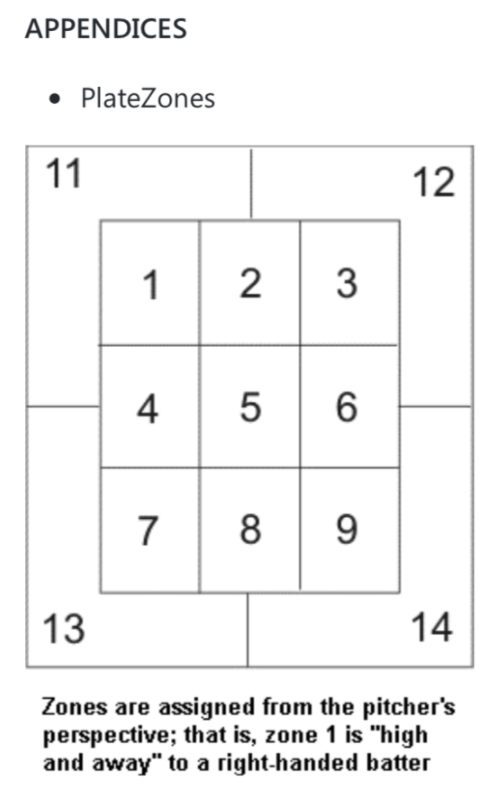


## 1.10 playerTwitterFollowers(train.csvのcolumn10番目)
その日の一部のプレイヤーの Twitter フォロワー数を含むネストされた JSON。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("playerTwitterFollowers",0) 
tmpdf.head(3)

Twitterのフォローデータは、MLBによってメジャーリーグプレーヤーのTwitter APIから毎月1日に収集され、2018年1月1日までさかのぼります。 すべてのプレーヤーがTwitterアカウントを持っている/持っているわけではない、プレーヤーがランダムにアカウントを作成/削除/復元する、または特定の日にフォロワーデータを収集できないその他のシナリオがあるため、このデータセットはすべての月にわたってすべてのプレーヤーを網羅しているわけではありません。

* date  : フォロワー数の日付。
* playerId  :   プレーヤーの一意の識別子。
* playerName : 
* accountName  : プレイヤーのTwitterアカウントの名前。
* twitterHandle  :   プレイヤーのツイッターハンドル。
* numberOfFollowers  :   フォロワー数

## 1.11 teamTwitterFollowers(train.csvのcolumn11番目)
その日の各チームの Twitter フォロワー数を含むネストされた JSON。

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("teamTwitterFollowers",0) 
tmpdf.head(3)

Twitterのフォローデータは、2018年1月1日までさかのぼって、毎月1日に、メジャーリーグの30チームすべてのTwitterAPIからMLBによって収集されました。

* date  : フォロワー数の日付。
* teamId  :   チームの一意の識別子。
* teamName : 
* accountName  : チームのTwitterアカウントの名前。
* twitterHandle  :   チームのツイッターハンドル。

やっとこ中身確認完了。おつかれさまでした。。。

# 2. 他のadditional data ( awards.csv, players.csv, seasons.csv, teams.csv)

## 2.1 starterにあったwidgetの練習(こんなことできるんだーと思いましたので・・・)

In [ ]:
df_names = ['seasons', 'teams', 'players', 'awards']

path = "../input/mlb-player-digital-engagement-forecasting"

In [ ]:
kaggle_data_tabs = widgets.Tab()
# widgetsにそれぞれのDataFrameをchildrenの中にタブで表示
kaggle_data_tabs.children = list([widgets.Output() for df_name in df_names])

In [ ]:
for index in range(len(df_names)):
    # タブのタイトルを設定
    kaggle_data_tabs.set_title(index, df_names[index])
    
    df = pd.read_csv(os.path.join(path,df_names[index]) + ".csv")
    
    # それぞれのタブにDataFrameを埋め込む
    with kaggle_data_tabs.children[index]:
        display(df)

In [ ]:
display(kaggle_data_tabs)

-----------細かく一つ一つ見ていきます-----------

## 2.2 Seasons.csv

In [ ]:
seasons = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/seasons.csv")
seasons

* seasonId : シーズンID
* seasonStartDate : シーズンスタート日
* seasonEndDate : シーズン終了日
* preSeasonStartDate : 1つ前のシーズンスタート日
* preSeasonEndDate : 1つ前のシーズンの終わりの日
* regularSeasonStartDate : レギュラーシーズンのスタートの日
* regularSeasonEndDate : レギュラーシーズンの終わりの日
* lastDate1stHalf : 1st halfの最終日
* allStarDate : オールスター戦の日付
* firstDate2ndHalf : 2nd halfの始まり日
* postSeasonStartDate : 次のシーズンのスタート日
* postSeasonEndDate : 次のシーズンの終わり日

## 2.3 teams.csv

In [ ]:
teams = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/teams.csv")
teams.head(3)

## teams.csv
* id - チームID
* name : 名前
* teamName : チームの名前
* teamCode : チームのコード
* shortName : 短い名前
* abbreviation : 略語
* locationName : 場所の名前
* leagueId : リーグのid
* leagueName : リーグの名前
* divisionId : 部門id
* divisionName : 部門名
* venueId : 会場id
* venueName : 会場名

## 2.4 players.csv

In [ ]:
players = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/players.csv")
players.head(3)

* playerId - Unique identifier for a player. : プレーヤーID-プレーヤーの一意の識別子。
* playerName : プレーヤの名前
* DOB - Player’s date of birth. : DOB-プレーヤーの生年月日。
* mlbDebutDate : MLBデビュー日
* birthCity : 生まれた町
* birthStateProvince : 出生州
* birthCountry : 生まれた国
* heightInches : 身長(inch)
* weight : 体重
* primaryPositionCode - Player’s primary position code : 主要ポジションコード
* primaryPositionName - player’s primary position : 主要ポジション名
* playerForTestSetAndFuturePreds - Boolean, true if player is among those for whom predictions are to be made in test data

: **ブール値、プレーヤーがテストデータで予測が行われる対象の1人である場合はtrue**

## 2.5 awards.csv

In [ ]:
awards = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/awards.csv")
awards.head(3)

このファイルには、日次データの開始前（つまり、2018年以前）にトレーニングセットのプレーヤーが獲得した賞が含まれています。

* awardDate - Date award was given. : 授与日 - 授与された日付。
* awardSeason - Season award was from. : アワードシーズン-シーズンアワードはからでした。
* awardId : アワードid
* awardName : アワード名
* playerId - Unique identifier for a player. : プレーヤーID-プレーヤーの一意の識別子。
* playerName : プレーヤーの名前
* awardPlayerTeamId : プレイヤーのチームID

# 3. Data Merge

とりあえず、スターターhttps://www.kaggle.com/ryanholbrook/getting-started-with-mlb-player-digital-engagement　

のコピーです。けっこう時間かかります。

In [ ]:
for name in df_names:
    globals()[name] = pd.read_csv(os.path.join(path,name)+ ".csv")

In [ ]:
#### Unnest various nested data within training (daily) data ####
daily_data_unnested_dfs = pd.DataFrame(data = {
  'dfName': training.drop('date', axis = 1).columns.values.tolist()
  })

daily_data_unnested_dfs['df'] = [pd.DataFrame() for row in 
  daily_data_unnested_dfs.iterrows()]

for df_index, df_row in daily_data_unnested_dfs.iterrows():
    nestedTableName = str(df_row['dfName'])
    
    date_nested_table = training[['date', nestedTableName]]
    
    date_nested_table = (date_nested_table[
      ~pd.isna(date_nested_table[nestedTableName])
      ].
      reset_index(drop = True)
      )
    
    daily_dfs_collection = []
    
    for date_index, date_row in date_nested_table.iterrows():
        daily_df = unpack_json(date_row[nestedTableName])
        
        daily_df['dailyDataDate'] = date_row['date']
        
        daily_dfs_collection = daily_dfs_collection + [daily_df]

    unnested_table = pd.concat(daily_dfs_collection,
      ignore_index = True).set_index('dailyDataDate').reset_index()

    # Creates 1 pandas df per unnested df from daily data read in, with same name
    globals()[df_row['dfName']] = unnested_table    
    
    daily_data_unnested_dfs['df'][df_index] = unnested_table

del training
gc.collect()



#### Get some information on each date in daily data (using season dates of interest) ####
dates = pd.DataFrame(data = 
  {'dailyDataDate': nextDayPlayerEngagement['dailyDataDate'].unique()})

dates['date'] = pd.to_datetime(dates['dailyDataDate'].astype(str))

dates['year'] = dates['date'].dt.year
dates['month'] = dates['date'].dt.month

dates_with_info = pd.merge(
  dates,
  seasons,
  left_on = 'year',
  right_on = 'seasonId'
  )

dates_with_info['inSeason'] = (
  dates_with_info['date'].between(
    dates_with_info['regularSeasonStartDate'],
    dates_with_info['postSeasonEndDate'],
    inclusive = True
    )
  )

dates_with_info['seasonPart'] = np.select(
  [
    dates_with_info['date'] < dates_with_info['preSeasonStartDate'], 
    dates_with_info['date'] < dates_with_info['regularSeasonStartDate'],
    dates_with_info['date'] <= dates_with_info['lastDate1stHalf'],
    dates_with_info['date'] < dates_with_info['firstDate2ndHalf'],
    dates_with_info['date'] <= dates_with_info['regularSeasonEndDate'],
    dates_with_info['date'] < dates_with_info['postSeasonStartDate'],
    dates_with_info['date'] <= dates_with_info['postSeasonEndDate'],
    dates_with_info['date'] > dates_with_info['postSeasonEndDate']
  ], 
  [
    'Offseason',
    'Preseason',
    'Reg Season 1st Half',
    'All-Star Break',
    'Reg Season 2nd Half',
    'Between Reg and Postseason',
    'Postseason',
    'Offseason'
  ], 
  default = np.nan
  )

#### Add some pitching stats/pieces of info to player game level stats ####

player_game_stats = (playerBoxScores.copy().
  # Change team Id/name to reflect these come from player game, not roster
  rename(columns = {'teamId': 'gameTeamId', 'teamName': 'gameTeamName'})
  )

# Adds in field for innings pitched as fraction (better for aggregation)
player_game_stats['inningsPitchedAsFrac'] = np.where(
  pd.isna(player_game_stats['inningsPitched']),
  np.nan,
  np.floor(player_game_stats['inningsPitched']) +
    (player_game_stats['inningsPitched'] -
      np.floor(player_game_stats['inningsPitched'])) * 10/3
  )

# Add in Tom Tango pitching game score (https://www.mlb.com/glossary/advanced-stats/game-score)
player_game_stats['pitchingGameScore'] = (40
#     + 2 * player_game_stats['outs']
    + 1 * player_game_stats['strikeOutsPitching']
    - 2 * player_game_stats['baseOnBallsPitching']
    - 2 * player_game_stats['hitsPitching']
    - 3 * player_game_stats['runsPitching']
    - 6 * player_game_stats['homeRunsPitching']
    )

# Add in criteria for no-hitter by pitcher (individual, not multiple pitchers)
player_game_stats['noHitter'] = np.where(
  (player_game_stats['gamesStartedPitching'] == 1) &
  (player_game_stats['inningsPitched'] >= 9) &
  (player_game_stats['hitsPitching'] == 0),
  1, 0
  )

player_date_stats_agg = pd.merge(
  (player_game_stats.
    groupby(['dailyDataDate', 'playerId'], as_index = False).
    # Some aggregations that are not simple sums
    agg(
      numGames = ('gamePk', 'nunique'),
      # Should be 1 team per player per day, but adding here for 1 exception:
      # playerId 518617 (Jake Diekman) had 2 games for different teams marked
      # as played on 5/19/19, due to resumption of game after he was traded
      numTeams = ('gameTeamId', 'nunique'),
      # Should be only 1 team for almost all player-dates, taking min to simplify
      gameTeamId = ('gameTeamId', 'min')
      )
    ),
  # Merge with a bunch of player stats that can be summed at date/player level
  (player_game_stats.
    groupby(['dailyDataDate', 'playerId'], as_index = False)
    [['runsScored', 'homeRuns', 'strikeOuts', 'baseOnBalls', 'hits',
      'hitByPitch', 'atBats', 'caughtStealing', 'stolenBases',
      'groundIntoDoublePlay', 'groundIntoTriplePlay', 'plateAppearances',
      'totalBases', 'rbi', 'leftOnBase', 'sacBunts', 'sacFlies',
      'gamesStartedPitching', 'runsPitching', 'homeRunsPitching', 
      'strikeOutsPitching', 'baseOnBallsPitching', 'hitsPitching',
      'inningsPitchedAsFrac', 'earnedRuns', 
      'battersFaced','saves', 'blownSaves', 'pitchingGameScore', 
      'noHitter'
      ]].
    sum()
    ),
  on = ['dailyDataDate', 'playerId'],
  how = 'inner'
  )

#### Turn games table into 1 row per team-game, then merge with team box scores ####
# Filter to regular or Postseason games w/ valid scores for this part
games_for_stats = games[
  np.isin(games['gameType'], ['R', 'F', 'D', 'L', 'W', 'C', 'P']) &
  ~pd.isna(games['homeScore']) &
  ~pd.isna(games['awayScore'])
  ]

# Get games table from home team perspective
games_home_perspective = games_for_stats.copy()

# Change column names so that "team" is "home", "opp" is "away"
games_home_perspective.columns = [
  col_value.replace('home', 'team').replace('away', 'opp') for 
    col_value in games_home_perspective.columns.values]

games_home_perspective['isHomeTeam'] = 1

# Get games table from away team perspective
games_away_perspective = games_for_stats.copy()

# Change column names so that "opp" is "home", "team" is "away"
games_away_perspective.columns = [
  col_value.replace('home', 'opp').replace('away', 'team') for 
    col_value in games_away_perspective.columns.values]

games_away_perspective['isHomeTeam'] = 0

# Put together games from home/away perspective to get df w/ 1 row per team game
team_games = (pd.concat([
  games_home_perspective,
  games_away_perspective
  ],
  ignore_index = True)
  )

# Copy over team box scores data to modify
team_game_stats = teamBoxScores.copy()

# Change column names to reflect these are all "team" stats - helps 
# to differentiate from individual player stats if/when joining later
team_game_stats.columns = [
  (col_value + 'Team') 
  if (col_value not in ['dailyDataDate', 'home', 'teamId', 'gamePk',
    'gameDate', 'gameTimeUTC'])
    else col_value
  for col_value in team_game_stats.columns.values
  ]

# Merge games table with team game stats
team_games_with_stats = pd.merge(
  team_games,
  team_game_stats.
    # Drop some fields that are already present in team_games table
    drop(['home', 'gameDate', 'gameTimeUTC'], axis = 1),
  on = ['dailyDataDate', 'gamePk', 'teamId'],
  # Doing this as 'inner' join excludes spring training games, postponed games,
  # etc. from original games table, but this may be fine for purposes here 
  how = 'inner'
  )

team_date_stats_agg = (team_games_with_stats.
  groupby(['dailyDataDate', 'teamId', 'gameType', 'oppId', 'oppName'], 
    as_index = False).
  agg(
    numGamesTeam = ('gamePk', 'nunique'),
    winsTeam = ('teamWinner', 'sum'),
    lossesTeam = ('oppWinner', 'sum'),
    runsScoredTeam = ('teamScore', 'sum'),
    runsAllowedTeam = ('oppScore', 'sum')
    )
   )

# Prepare standings table for merge w/ player digital engagement data
# Pick only certain fields of interest from standings for merge
standings_selected_fields = (standings[['dailyDataDate', 'teamId', 
  'streakCode', 'divisionRank', 'leagueRank', 'wildCardRank', 'pct'
  ]].
  rename(columns = {'pct': 'winPct'})
  )

# Change column names to reflect these are all "team" standings - helps 
# to differentiate from player-related fields if/when joining later
standings_selected_fields.columns = [
  (col_value + 'Team') 
  if (col_value not in ['dailyDataDate', 'teamId'])
    else col_value
  for col_value in standings_selected_fields.columns.values
  ]

standings_selected_fields['streakLengthTeam'] = (
  standings_selected_fields['streakCodeTeam'].
    str.replace('W', '').
    str.replace('L', '').
    astype(float)
    )

# Add fields to separate winning and losing streak from streak code
standings_selected_fields['winStreakTeam'] = np.where(
  standings_selected_fields['streakCodeTeam'].str[0] == 'W',
  standings_selected_fields['streakLengthTeam'],
  np.nan
  )

standings_selected_fields['lossStreakTeam'] = np.where(
  standings_selected_fields['streakCodeTeam'].str[0] == 'L',
  standings_selected_fields['streakLengthTeam'],
  np.nan
  )

standings_for_digital_engagement_merge = (pd.merge(
  standings_selected_fields,
  dates_with_info[['dailyDataDate', 'inSeason']],
  on = ['dailyDataDate'],
  how = 'left'
  ).
  # Limit down standings to only in season version
  query("inSeason").
  # Drop fields no longer necessary (in derived values, etc.)
  drop(['streakCodeTeam', 'streakLengthTeam', 'inSeason'], axis = 1).
  reset_index(drop = True)
  )

#### Merge together various data frames to add date, player, roster, and team info ####
# Copy over player engagement df to add various pieces to it
player_engagement_with_info = nextDayPlayerEngagement.copy()

# Take "row mean" across targets to add (helps with studying all 4 targets at once)
player_engagement_with_info['targetAvg'] = np.mean(
  player_engagement_with_info[['target1', 'target2', 'target3', 'target4']],
  axis = 1)

# Merge in date information
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  dates_with_info[['dailyDataDate', 'date', 'year', 'month', 'inSeason',
    'seasonPart']],
  on = ['dailyDataDate'],
  how = 'left'
  )

# Merge in some player information
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  players[['playerId', 'playerName', 'DOB', 'mlbDebutDate', 'birthCity',
    'birthStateProvince', 'birthCountry', 'primaryPositionName']],
   on = ['playerId'],
   how = 'left'
   )

# Merge in some player roster information by date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  (rosters[['dailyDataDate', 'playerId', 'statusCode', 'status', 'teamId']].
    rename(columns = {
      'statusCode': 'rosterStatusCode',
      'status': 'rosterStatus',
      'teamId': 'rosterTeamId'
      })
    ),
  on = ['dailyDataDate', 'playerId'],
  how = 'left'
  )
    
# Merge in team name from player's roster team
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  (teams[['id', 'teamName']].
    rename(columns = {
      'id': 'rosterTeamId',
      'teamName': 'rosterTeamName'
      })
    ),
  on = ['rosterTeamId'],
  how = 'left'
  )

# Merge in some player game stats (previously aggregated) from that date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  player_date_stats_agg,
  on = ['dailyDataDate', 'playerId'],
  how = 'left'
  )

# Merge in team name from player's game team
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  (teams[['id', 'teamName']].
    rename(columns = {
      'id': 'gameTeamId',
      'teamName': 'gameTeamName'
      })
    ),
  on = ['gameTeamId'],
  how = 'left'
  )

# Merge in some team game stats/results (previously aggregated) from that date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  team_date_stats_agg.rename(columns = {'teamId': 'gameTeamId'}),
  on = ['dailyDataDate', 'gameTeamId'],
  how = 'left'
  )

# Merge in player transactions of note on that date
    
# Merge in some pieces of team standings (previously filter/processed) from that date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  standings_for_digital_engagement_merge.
    rename(columns = {'teamId': 'gameTeamId'}),
  on = ['dailyDataDate', 'gameTeamId'],
  how = 'left'
  )

display(player_engagement_with_info)

In [ ]:
player_engagement_with_info.info()

output結果をreferenceできるように、一応pickleで保存しておきます。

In [ ]:
player_engagement_with_info.to_pickle("player_engagement_with_info.pkl")

#### スターターではここからkerasで簡単なモデル作成をしていますので、興味ある方はそちらをご覧ください。

### 以下、検証用として、target1～4をすべて中間値(スコア上がるため、v8でmeanからmedianに変更しました)でsubmitします。

In [ ]:
t1_median = player_engagement_with_info["target1"].median()
t2_median = player_engagement_with_info["target2"].median()
t3_median = player_engagement_with_info["target3"].median()
t4_median = player_engagement_with_info["target4"].median()

In [ ]:
print(t1_median,t2_median,t3_median,t4_median)

# 4. submitの形式
riiidの https://www.kaggle.com/chumajin/eda-for-biginner　で解説したのと同じく、1部のtest dataをget → 1部を予測　→　1部を提出　をどんどん繰り返していく方式です。
今回は1日分のtest data→次の日を予測提出、んで、次の日のtest data→その次の日を予測、提出　の流れです。


## **↓のmake_envは1回しか実行できません。**
## **失敗したら、データをrestart(上の方のFactory resetボタンを押す)して、再度やることになりますので、注意が必要です!**

#### 最終形はこんな感じです(スターターから抜粋。解説用に少し細かくやっていきます

In [ ]:
"""
if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb

    env = mlb.make_env()
    iter_test = env.iter_test()

    for (test_df, sample_prediction_df) in iter_test:
    
        # Example: unpack a dataframe from a json column
        today_games = unpack_json(test_df['games'].iloc[0])
    
        # Make your predictions for the next day's engagement
        sample_prediction_df['target1'] = 100.00
    
        # Submit your predictions 
        env.predict(sample_prediction_df)


"""

#### ここから↑のサンプルコードを少し解説

mlbのダウンロード

In [ ]:
if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb

envとiter_testの定義 (お決まりの作業と思ってもらえれば)

In [ ]:
env = mlb.make_env()
iter_test = env.iter_test()

iter_testの中身を見てみる (とりあえずbreakで1個だけ見る。break外すとエラーでます。理由はそのあと解説しています)

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    display(test_df)
    display(sample_prediction_df)
    break

1日分のtest dataと、submissionファイルが出てくるのがわかる


ここで、submissionファイルに予測値を記入して、提出しないと、次の日のtest dataを受け取ることができないというエラーが出る(以下のように、もう一度走らせると怒られる)

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    display(test_df)
    display(sample_prediction_df)
    break

なので、一度submissionファイルに記入して提出してあげないといけません。ここではお試しに、先ほどのtargetのそれぞれの中間値を全部入れてみます。

In [ ]:
sample_prediction_df["target1"] = t1_median
sample_prediction_df["target2"] = t2_median
sample_prediction_df["target3"] = t3_median
sample_prediction_df["target4"] = t4_median


sample_prediction_df

予測値を入れたらこの時点で一度下記のコードでsubmitします

In [ ]:
env.predict(sample_prediction_df)

そうすると、次の日のデータが受け取れるようになります。(以下のように先ほどと同じコードを流してもエラーで怒られません)

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    display(test_df)
    display(sample_prediction_df)
    break

以下のスターターのコードをもう一度みて見ると、for文の中でこれを繰り返してsubmitしていることがわかります。

基本的には以下のfor文の中身を、test dfの前処理と、predictionして、sample_prediction_dfの書き換え、env.predictで提出していく流れですね。

riiidコンペの場合は、一つ前の情報の正解が流れてきてましたので、それを使って次の予測のためのデータとして使用していました(今回もおそらくそうなのかな??)。

In [ ]:
"""
if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb

    env = mlb.make_env()
    iter_test = env.iter_test()

    for (test_df, sample_prediction_df) in iter_test:
    
        # Example: unpack a dataframe from a json column
        today_games = unpack_json(test_df['games'].iloc[0])
    
        # Make your predictions for the next day's engagement
        sample_prediction_df['target1'] = 100.00
    
        # Submit your predictions 
        env.predict(sample_prediction_df)


"""

## 今回はこのままsubmitしたいので、2回目の提出後にfor文で最後まで回します。

In [ ]:
# 2回目の提出

sample_prediction_df["target1"] = t1_median
sample_prediction_df["target2"] = t2_median
sample_prediction_df["target3"] = t3_median
sample_prediction_df["target4"] = t4_median
env.predict(sample_prediction_df)


In [ ]:
# 残り最後まで

for (test_df, sample_prediction_df) in iter_test:
    
        # Example: unpack a dataframe from a json column
        #today_games = unpack_json(test_df['games'].iloc[0])
    
        # Make your predictions for the next day's engagement
        sample_prediction_df["target1"] = t1_median
        sample_prediction_df["target2"] = t2_median
        sample_prediction_df["target3"] = t3_median
        sample_prediction_df["target4"] = t4_median
    
        # Submit your predictions 
        env.predict(sample_prediction_df)

ご参考> コード要件

* これはコードコンペティションです
* このコンテストへの提出は、ノートブックを通じて行う必要があります。コミット後に[送信]ボタンをアクティブにするには、次の条件が満たされている必要があります。
* 
* CPUノートブック<= 6時間の実行時間
* GPUノートブック<= 6時間の実行時間
* **インターネットアクセスが無効**
* 事前にトレーニングされたモデルを含む、無料で公開されている外部データが許可されます
* 提出は、mlbPythonモジュールを使用して行う必要があります

# ここまで読んでいただいてありがとうございます！
# お役にたてば、upvote/followいただけたら嬉しいです！
# よろしくお願いいたします !!